### __01. High level Understanding on building RAG system__

In this we'll build RAG system at high level with `LangChain` ecosystem


[Build a RAG agent with LangChain](https://docs.langchain.com/oss/python/langchain/rag)

In this we'll cover :- 

1. Indexing -> Pipeline for ingesting data from a source and indexing it
2. Retrieval -> Takes the user query at run time and retrieves the relevant data from the index
3. Generation -> passes that to the model to generate the output 

__Components__

1. Chat model :- We'll be using OpenSource model from HuggingFace Hub 
2. Embeddings model :- We'll be using HuggingFace embedding model
3. Vector Store :- We'll use Chroma from langchain_community


Later, We'll see how can you host your own LLM and use in the RAG (chat model component) to bring the Cost down and things like tokens limit, selecting chat and embedding models etc,.

For now we'll just focus on building a working system.

In [ ]:
# 1. Install the dependencies 

!uv pip install -r requirements.txt

In [ ]:
import bs4 
import tiktoken
import numpy as np
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_huggingface import HuggingFaceEndpoint, HuggingFaceEmbeddings, ChatHuggingFace


from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

__First let's understand three things with an example__

1. How does sentences or documents get's tokenized 
2. How does sentences or documents get's converted into embeddings (vectore space with semantic meanings)
3. On what basic data is fetched for user query from the documents  

In [2]:
# Tokenization of the documents 

question = 'What is my name ?'
document = 'I am Pawan and I like mangoes'
# document = 'What is my name ?'


def num_tokens_from_string(string:str, encoding_name:str) -> int: 
    ''' 
    takes input of string and encoding methods and return numbers of token in string 
    '''

    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

print(num_tokens_from_string(question, 'cl100k_base'))
print(num_tokens_from_string(document, 'cl100k_base'))

5
9


In [3]:
# Embedding [We'll be using HuggingFace embedding model

embd = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

query_result = embd.embed_query(question)
document_result = embd.embed_query(document)

print(len(query_result), len(document_result))

768 768


In [4]:
print(query_result[:8])

[0.07835740596055984, 0.020956793799996376, 0.012268691323697567, -0.03219913691282272, 0.04329903423786163, 0.025946352630853653, 0.01887800544500351, 0.0015160075854510069]


In [5]:
# Cosine similarity [We'll check how much similar two documents are, and you can play with this by changing que and doc above]

def cosine_similarity(vector1, vector2):

    dot_product = np.dot(vector1, vector2)

    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 =  np.linalg.norm(vector2)

    return dot_product/(norm_vector1 * norm_vector2)

print(cosine_similarity(query_result, document_result))

0.29109624303852394


### Let's start the main part


 __Indexing__


In [6]:
# First we'll read a blog post from the internet [Extrinsic Hallucinations in LLMs - How LLM's Lie]

loader = WebBaseLoader(
    web_path= ('https://lilianweng.github.io/posts/2024-07-07-hallucination/'),
    bs_kwargs = dict(parse_only = bs4.SoupStrainer(class_ = ('post-content','post-title','post-header'))),  # these are defined based on the blog website attribute as shown below
)

blog_doc = loader.load()

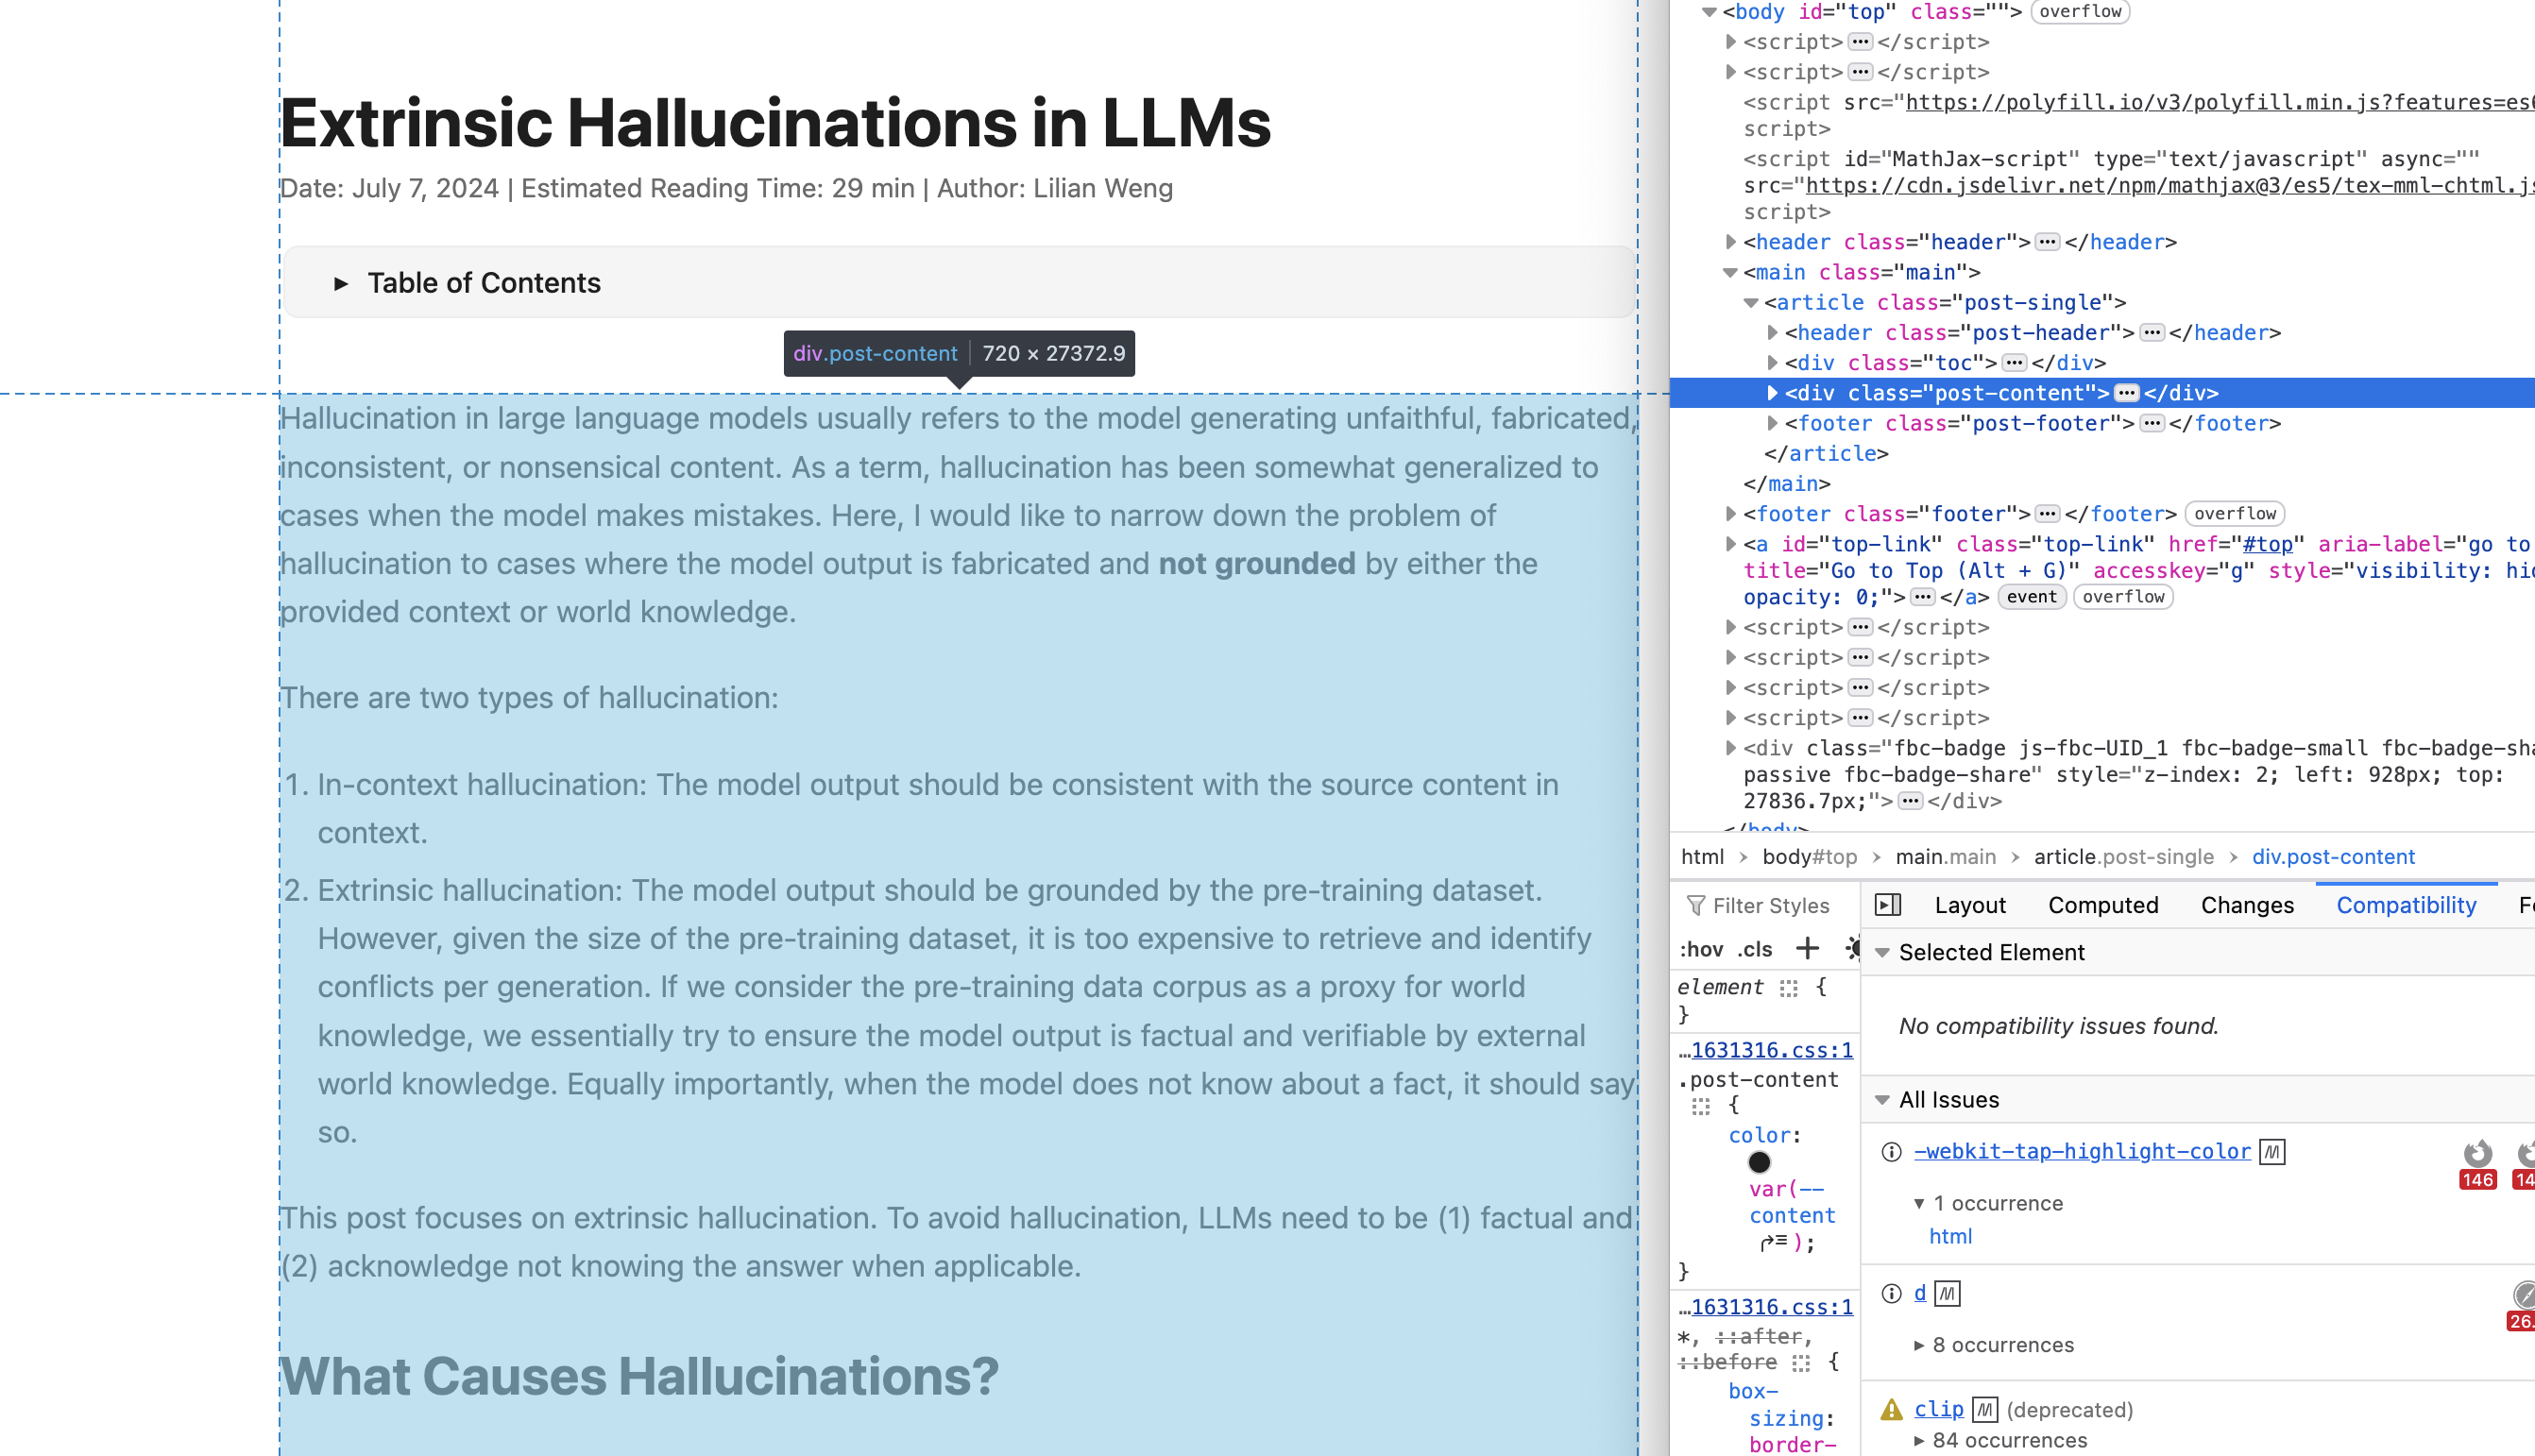

In [7]:
# let's understand blog_doc object 

print(type(blog_doc))
print(len(blog_doc))

<class 'list'>
1


In [8]:
print(blog_doc[0].metadata)
print(blog_doc[0].page_content)

{'source': 'https://lilianweng.github.io/posts/2024-07-07-hallucination/'}


      Extrinsic Hallucinations in LLMs
    
Date: July 7, 2024  |  Estimated Reading Time: 29 min  |  Author: Lilian Weng


Hallucination in large language models usually refers to the model generating unfaithful, fabricated, inconsistent, or nonsensical content. As a term, hallucination has been somewhat generalized to cases when the model makes mistakes. Here, I would like to narrow down the problem of hallucination to cases where the model output is fabricated and not grounded by either the provided context or world knowledge.
There are two types of hallucination:

In-context hallucination: The model output should be consistent with the source content in context.
Extrinsic hallucination: The model output should be grounded by the pre-training dataset. However, given the size of the pre-training dataset, it is too expensive to retrieve and identify conflicts per generation. If we consider the pre-training da

__Now we have the document, let's working on the splitting into chunks__



[Text splitters by Langchin](https://docs.langchain.com/oss/python/integrations/splitters)

In [9]:
# Splitting 

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size = 3000,
    chunk_overlap = 50
)

splits = text_splitter.split_documents(blog_doc)

In [10]:
print(f' No of documents : {len(splits)}')
print(type(splits))

splits[:5]

 No of documents : 4
<class 'list'>


[Document(metadata={'source': 'https://lilianweng.github.io/posts/2024-07-07-hallucination/'}, page_content="Extrinsic Hallucinations in LLMs\n    \nDate: July 7, 2024  |  Estimated Reading Time: 29 min  |  Author: Lilian Weng\n\n\nHallucination in large language models usually refers to the model generating unfaithful, fabricated, inconsistent, or nonsensical content. As a term, hallucination has been somewhat generalized to cases when the model makes mistakes. Here, I would like to narrow down the problem of hallucination to cases where the model output is fabricated and not grounded by either the provided context or world knowledge.\nThere are two types of hallucination:\n\nIn-context hallucination: The model output should be consistent with the source content in context.\nExtrinsic hallucination: The model output should be grounded by the pre-training dataset. However, given the size of the pre-training dataset, it is too expensive to retrieve and identify conflicts per generation.

__Let's store document into the vector database__


[Vectore Databaes](https://docs.langchain.com/oss/python/integrations/vectorstores#chroma)

In [11]:
vectorstore = Chroma.from_documents(documents=splits,
                                    embedding=HuggingFaceEmbeddings())


retriever = vectorstore.as_retriever(search_kwargs = {'k':4})

### __Retrieval__

In [12]:
docs = retriever.invoke('why does llm hallucinate')
docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2024-07-07-hallucination/'}, page_content="Extrinsic Hallucinations in LLMs\n    \nDate: July 7, 2024  |  Estimated Reading Time: 29 min  |  Author: Lilian Weng\n\n\nHallucination in large language models usually refers to the model generating unfaithful, fabricated, inconsistent, or nonsensical content. As a term, hallucination has been somewhat generalized to cases when the model makes mistakes. Here, I would like to narrow down the problem of hallucination to cases where the model output is fabricated and not grounded by either the provided context or world knowledge.\nThere are two types of hallucination:\n\nIn-context hallucination: The model output should be consistent with the source content in context.\nExtrinsic hallucination: The model output should be grounded by the pre-training dataset. However, given the size of the pre-training dataset, it is too expensive to retrieve and identify conflicts per generation.

### __Generation__


__For this part you need to set your Keys for accessing the model__ 

1. If you are using OpenAI models 
2. If you are using Opensource model from HuggigFace (in this case) [Inference Providers](https://huggingface.co/docs/inference-providers/en/index?python-clients=huggingface_hub)


- Here is how you can set up keys in your env (after creating them on respective websites)

```python
import os
os.environ["OPENAI_API_KEY"] = " "
os.environ["HUGGINGFACEHUB_API_TOKEN"] = " "
```

and you can check using below commands :- 

```python
print(os.getenv("OPENAI_API_KEY"))
print(os.getenv("HUGGINGFACEHUB_API_TOKEN"))
```

In [13]:
# prompt 

template = """
Answer the question based only on the following Context:
{context}

Question:
{question}
"""

prompt = ChatPromptTemplate.from_template(template)
print(prompt)

input_variables=['context', 'question'] input_types={} partial_variables={} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='\nAnswer the question based only on the following Context:\n{context}\n\nQuestion:\n{question}\n'), additional_kwargs={})]


In [14]:
llm = ChatHuggingFace(
    llm = HuggingFaceEndpoint(
        repo_id="deepseek-ai/DeepSeek-V3.2",
        task="conversational",  
        temperature=0.7,
        max_new_tokens=256,
        streaming=False
))


chain = prompt | llm

chain

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='\nAnswer the question based only on the following Context:\n{context}\n\nQuestion:\n{question}\n'), additional_kwargs={})])
| ChatHuggingFace(llm=HuggingFaceEndpoint(repo_id='deepseek-ai/DeepSeek-V3.2', max_new_tokens=256, temperature=0.7, stop_sequences=[], server_kwargs={}, model_kwargs={}, model='deepseek-ai/DeepSeek-V3.2', client=<InferenceClient(model='deepseek-ai/DeepSeek-V3.2', timeout=120)>, async_client=<InferenceClient(model='deepseek-ai/DeepSeek-V3.2', timeout=120)>, task='conversational'), model_id='deepseek-ai/DeepSeek-V3.2', temperature=0.7, top_p=0.95, max_tokens=256, model_kwargs={})

In [15]:
response = chain.invoke(
    
      {"context" : docs,      
       "question": "why does llm hallucinate ?"}
)

response

AIMessage(content="Based solely on the provided context, LLMs hallucinate for several reasons:\n\n1. **Pre-training Data Issues**: Data used for pre-training (often crawled from the public Internet) can be out-of-date, missing, or incorrect. The model learns this flawed information because it is trained to maximize the log-likelihood of the training data.\n\n2. **Fine-Tuning New Knowledge**: Introducing new knowledge during fine-tuning (like supervised fine-tuning or RLHF) can encourage hallucinations. Studies show that:\n   - LLMs learn new knowledge slower than information consistent with their pre-existing knowledge.\n   - Once new knowledge is learned, it increases the model's tendency to hallucinate.\n\n3. **Inference Issues**: Techniques that add randomness during generation (like nucleus sampling) can lead to more hallucinations compared to greedy sampling.\n\n4. **Lack of Grounding**: Without being anchored to external, verified knowledge sources (like in Retrieval-Augmented Ge

In [16]:
print(response.content)

Based solely on the provided context, LLMs hallucinate for several reasons:

1. **Pre-training Data Issues**: Data used for pre-training (often crawled from the public Internet) can be out-of-date, missing, or incorrect. The model learns this flawed information because it is trained to maximize the log-likelihood of the training data.

2. **Fine-Tuning New Knowledge**: Introducing new knowledge during fine-tuning (like supervised fine-tuning or RLHF) can encourage hallucinations. Studies show that:
   - LLMs learn new knowledge slower than information consistent with their pre-existing knowledge.
   - Once new knowledge is learned, it increases the model's tendency to hallucinate.

3. **Inference Issues**: Techniques that add randomness during generation (like nucleus sampling) can lead to more hallucinations compared to greedy sampling.

4. **Lack of Grounding**: Without being anchored to external, verified knowledge sources (like in Retrieval-Augmented Generation or RAG), models may 

In [17]:
print(response.usage_metadata)
response.response_metadata

{'input_tokens': 9846, 'output_tokens': 242, 'total_tokens': 10088}


{'token_usage': {'completion_tokens': 242,
  'prompt_tokens': 9846,
  'total_tokens': 10088},
 'model_name': 'deepseek-ai/DeepSeek-V3.2',
 'system_fingerprint': '',
 'finish_reason': 'stop',
 'logprobs': None}

__Doing this though pipeline rather than feeding manually__

In [18]:
rag_chain = ({"context" : retriever,  "question": RunnablePassthrough()} 
             | prompt
             | llm 
             | StrOutputParser()
)

rag_chain

{
  context: VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x16a5246b0>, search_kwargs={'k': 4}),
  question: RunnablePassthrough()
}
| ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='\nAnswer the question based only on the following Context:\n{context}\n\nQuestion:\n{question}\n'), additional_kwargs={})])
| ChatHuggingFace(llm=HuggingFaceEndpoint(repo_id='deepseek-ai/DeepSeek-V3.2', max_new_tokens=256, temperature=0.7, stop_sequences=[], server_kwargs={}, model_kwargs={}, model='deepseek-ai/DeepSeek-V3.2', client=<InferenceClient(model='deepseek-ai/DeepSeek-V3.2', timeout=120)>, async_client=<InferenceClient(model='deepseek-ai/DeepSeek-V3.2', timeout=120)>, task='conversational'), model_id='deepseek-ai/De

In [19]:
response_updated = rag_chain.invoke("why does llm hallucinate?")

In [20]:
print(response_updated)

Based solely on the provided context, LLMs hallucinate for several reasons:

1.  **Pre-training Data Issues:** The enormous pre-training corpus (often crawled from the public internet) contains out-of-date, missing, or incorrect information. The model can incorrectly memorize this flawed information by maximizing log-likelihood.

2.  **Fine-tuning New Knowledge:** Introducing new knowledge during fine-tuning (like supervised fine-tuning or RLHF) can encourage hallucinations. Research (Gekhman et al. 2024) found that:
    *   LLMs learn new knowledge from fine-tuning examples slower than they learn examples consistent with their pre-existing knowledge.
    *   Once these new-knowledge examples are eventually learned, they increase the model's tendency to hallucinate.


----